In [3]:
import json
import pandas as pd
import os
import seaborn as sns

DATA_PREFIX = "../../datasets.nosync/"
RESULTS_PREFIX = "../../results_fs/"

def load_prevend_nmr():
    X = pd.read_csv(DATA_PREFIX + f"nmr_train.csv")
    file_name = f"nmr_featureselection.json"
    with open(os.path.join(RESULTS_PREFIX, file_name), "r") as f:
        feature_selectors = json.load(f)
    return X, feature_selectors

def load_prevend_clinical():
    X = pd.read_csv(DATA_PREFIX + f"clinical_train.csv")
    X = X.drop(["CENSORED", "upper_bound", "lower_bound"], axis=1, inplace=False)
    X = X.fillna(X.median())
    # X = X.drop(["UV54_2B"], axis=1, inplace=False) # necessary for non-ex dataset
    file_name = f"clinical_featureselection.json"
    with open(os.path.join(RESULTS_PREFIX, file_name), "r") as f:
        feature_selectors = json.load(f)
    return X, feature_selectors

def load_prevend_nmr_dim_reduction():
    file_name = f"nmr_dimreduction.json"
    with open(os.path.join(RESULTS_PREFIX, file_name), "r") as f:
        feature_selectors = json.load(f)
    return feature_selectors

def load_prevend_dim_reduction():
    file_name = f"clinical_dimreduction.json"
    with open(os.path.join(RESULTS_PREFIX, file_name), "r") as f:
        feature_selectors = json.load(f)
    return feature_selectors

def print_selected_features(X, feature_selectors):
    for feat_selector, result in feature_selectors.items():
        features_selected = result["features_selected"]
        print(feat_selector)
        for subset in features_selected:
            print(subset)
            print(list(X[[X.columns[i] for i in subset]].columns))
        print("\n")

In [4]:
X_clinical, feature_selectors_clinical = load_prevend_clinical()
X_nmr, feature_selectors_nmr = load_prevend_nmr()

In [58]:
import numpy as np

def calculate_redundancy(X, feature_selectors):
    X = X.to_numpy()
    n_features = X.shape[1]
    redundancy_rates = {feat_selector: {} for feat_selector in feature_selectors}

    for feat_selector, result in feature_selectors.items():
        features_selected = result["features_selected"]
        rates = []
        for subset in features_selected:
            corr = []
            for i in subset:
                for j in subset:
                    if i < j:
                        if (
                            np.unique(X[:, i]).shape[0] > 1
                            and np.unique(X[:, j]).shape[0] > 1
                        ):
                            corr.append(abs(np.corrcoef(X[:, i], X[:, j])[0, 1]))
                        else:
                            continue
            redundancy_rate = 1 / (n_features * (n_features - 1)) * sum(corr)
            rates.append(redundancy_rate)
        redundancy_rates[feat_selector]["rate"] = np.mean(rates)
        redundancy_rates[feat_selector]["std"] = np.std(rates)
    return dict(
        sorted(redundancy_rates.items(), key=lambda item: item[1]["rate"])
    )

redundancy_rates_clinical = calculate_redundancy(X_clinical, feature_selectors_clinical)
redundancy_rates_nmr = calculate_redundancy(X_nmr, feature_selectors_nmr)

In [ ]:
print_selected_features(X_clinical, feature_selectors_clinical)
print_selected_features(X_nmr, feature_selectors_nmr)

In [5]:
import matplotlib.pyplot as plt

def plot(feature_selectors, dim_reduction_results, save_path, title, red_rates=None):
    colors = {
        "boruta": "orange",
        "featboost_aft": "green",
        "xgb": "red",
        "pca": "blue",
        "umap": "purple",
    }
    markers = {
        "boruta": "s",
        "featboost_aft": "^",
        "xgb": "x",
        "pca": "o",
        "umap": "D",
    }
    sub_dict = {
        "boruta": "Boruta",
        "featboost_aft": f"FeatBoost-X",
        "xgb": "XGBoost",
        "pca": "PCA",
        "umap": "UMAP",
    }
    if red_rates:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

    sns.despine()
    for feat_selector in feature_selectors:
        ax1.plot(
            range(1, len(feature_selectors[feat_selector]["mean_cindex"]) + 1),
            feature_selectors[feat_selector]["mean_cindex"],
            label=sub_dict[feat_selector],
            marker=markers[feat_selector],
            linestyle="-",
            markersize=5,
            color=colors[feat_selector],
        )
    for dim_reductor in dim_reduction_results:
        ax1.plot(
            range(1, len(dim_reduction_results[dim_reductor]["mean_cindex"]) + 1),
            dim_reduction_results[dim_reductor]["mean_cindex"],
            label=sub_dict[dim_reductor],
            marker=markers[dim_reductor],
            linestyle="--",
            markersize=5,
            color=colors[dim_reductor],
        )
    if red_rates:
        bar_positions = np.arange(len(red_rates))
        bar_width = 0.4  # Adjust as needed

        for i, (selector, data) in enumerate(red_rates.items()):
            label = sub_dict[selector]
            ax2.bar(
                i,
                data["rate"],
                width=bar_width,
                yerr=data["std"],
                label=label,
                color=colors[selector],
                capsize=5,
            )
            ax2.set_xlabel("Feature Selector", fontsize=14)
            ax2.set_ylabel("Redundancy Rate", fontsize=14)
            ax2.tick_params(axis="both", which="major", labelsize=12)
            ax2.set_xticks(bar_positions)
            ax2.set_xticklabels(
                [sub_dict[selector] for selector in red_rates.keys()], rotation=45,
            )
            ax2.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
            ax2.title.set_text("Redundancy Rate per Feature Selector")

    ax1.set_ylabel("C-Index", fontsize=12)
    ax1.tick_params(axis="y", labelcolor="black", labelsize=10)

    # Refine the legend
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(
        lines,
        labels,
        fancybox=True,
        shadow=True,
        ncol=2,
        fontsize=10,
    )
    ax1.set_ylim(0.5, 0.9)
    ax1.set_xlim(0, 50)
    ax1.grid(color="grey", linestyle="--", linewidth=0.5, axis="y")

    ax1.title.set_text(f"{title} feature selection C-index per added feature")
    ax1.set_xlabel("Number of Features", fontsize=12)
    # ax1.get_legend().remove()
    # fig.suptitle(f"NMR Feature Selection C-Index Per Added Feature", fontsize=16)
    plt.tight_layout()
    # plt.show()
    plt.savefig(save_path)

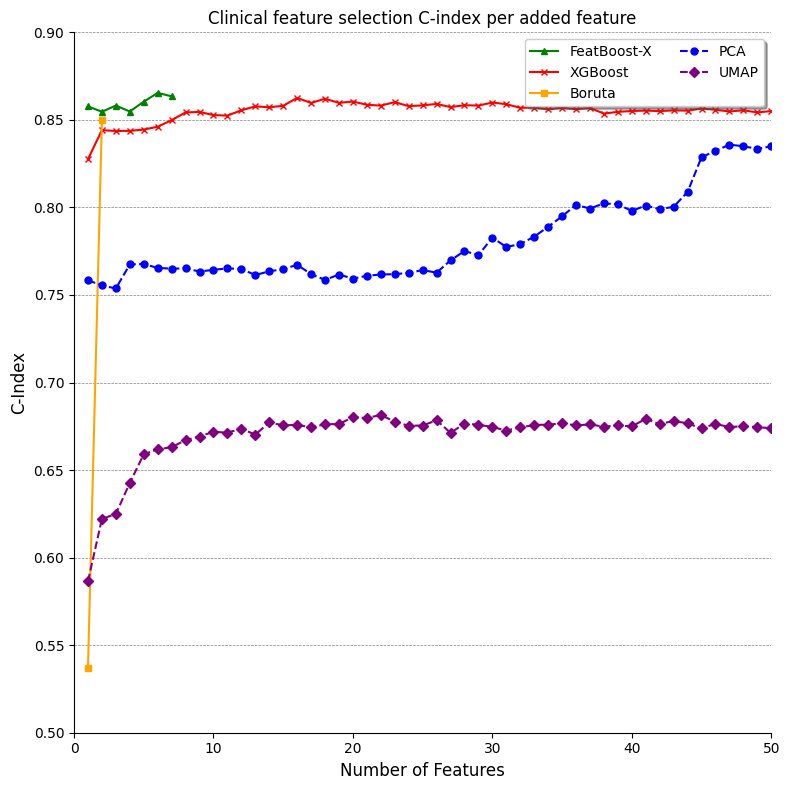

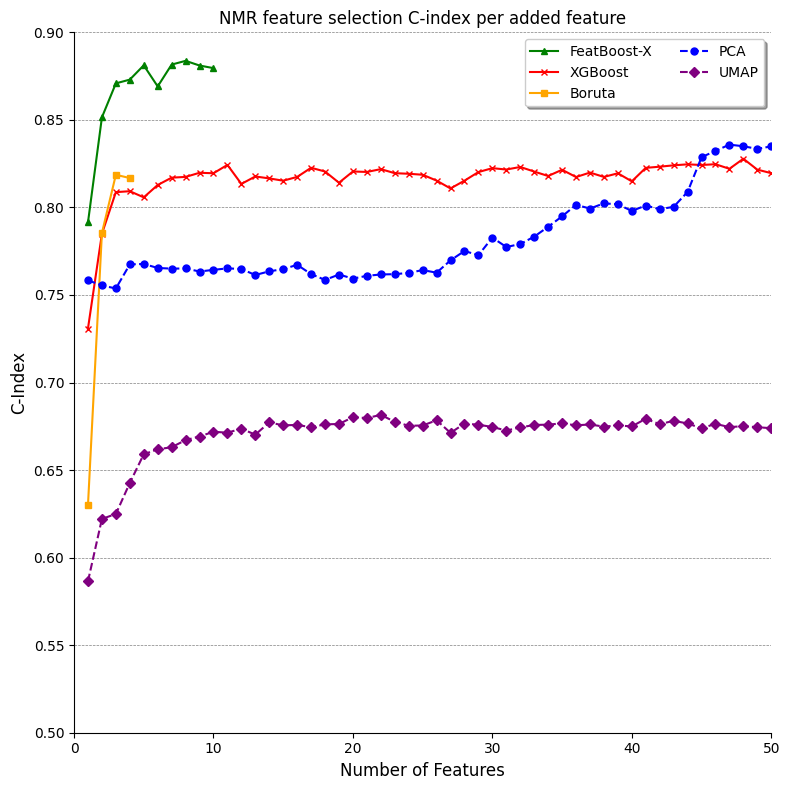

In [6]:
plot(
    feature_selectors_clinical,
    load_prevend_dim_reduction(),
    f"../../results_fs/clinical_feature_selection.pdf",
    "Clinical",
)
plot(
    feature_selectors_nmr,
    load_prevend_dim_reduction(),
    f"../../results_fs/nmr_feature_selection.pdf",
    "NMR",
)

/Users/otoz/miniconda3/envs/thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


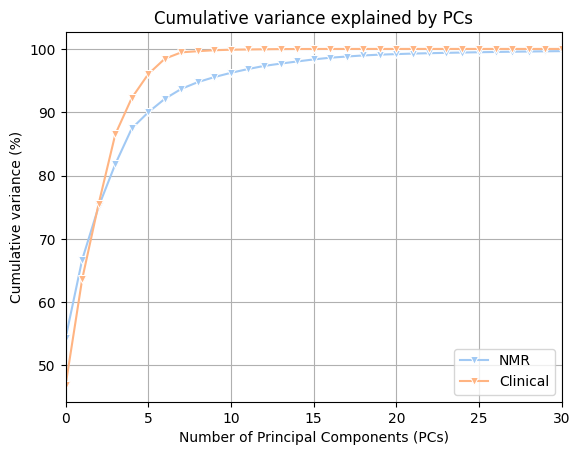

In [1]:
# set src
import sys
sys.path.append("../../src")
from visualization import plot_cumulative_variance

plot_cumulative_variance()